<a href="https://colab.research.google.com/github/emyesme/CalcificationDetection/blob/Emily/calcificationTestImageProcessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [110]:
#just once to install opencv
!pip install opencv-python

In [111]:
#just once to install matplotlib
!pip install matplotlib

In [112]:
#just once to install numpy
!pip install numpy

In [113]:
#just once to install google.colab
!pip install google-colab

In [114]:
!pip install PyWavelets

In [115]:
!pip install image_dehazer

In [116]:
!pip install -U scikit-image

In [117]:
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [118]:
import os 

#first put a shortcut in your drive to the image processing folder

DATA_DIR = os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Image Processing and Analysis 2022',
                        'projects',
                        'Calcification Detection',
                        'dataset')


print(os.listdir(DATA_DIR))

['normals.txt', 'images', 'groundtruths', 'masks']


In [119]:
# os.listdir(DATA_DIR + "/groundtruths")

In [120]:
# import opencv
import cv2
# import numpy
import numpy as np


In [121]:
# preprocessing
# here explain what you code
def preprocessingWavelet(matrix, mask):
  # wavelet high pass, low pass or low pass, high pass, high pass high pass.
  import pywt  

  # enhancement
  # Comparing the Performance of Image Enhancement Methods
  # to Detect Microcalcification Clusters in Digital Mammography, Moradmand, Hajar, 2012

  # Five-level   discrete   wavelet decomposition  was  employed  by  using  Asymmetric Daubechies  of  order  8; 

  # normal wavelet from stackoverflow
  # convert to grayscale
  grayscale = cv2.cvtColor(matrix, cv2.COLOR_BGR2GRAY)

  # convert to float
  arrayFloat = np.float32(grayscale)
  arrayFloat /= 255
  
  # compute coefficients
  coeffs = pywt.wavedec2(arrayFloat,'haar',level=10)

  #process coefficients
  coeffs_H = list(coeffs)
  coeffs_H[0] *= 0

  # reconstruction
  arrayFloat_H = pywt.waverec2(coeffs_H, 'haar')
  arrayFloat_H *= 255
  arrayFloat_H = np.uint8(arrayFloat_H)

  preprocessed = arrayFloat_H
  return preprocessed

In [122]:
# preprocessing
# here explain what you code
def preprocessingDeHazingPy(matrix, mask):
  # https://link.springer.com/chapter/10.1007/978-3-319-68548-9_27
  # the professor say we can take the grays in the mammogram as haze. so use dehazing

  # still no the hazing method that he use this is just one found in a python library
  # https://github.com/Utkarsh-Deshmukh/Single-Image-Dehazing-Python
  # dehazing

  import image_dehazer	# Load the library

  hazeCorrectedImg = image_dehazer.remove_haze(matrix)		# Remove Haze

  preprocessed = hazeCorrectedImg
  return preprocessed

In [142]:
# dehaze single image using dark channel prior and guided filter
# taken from a repository 
# https://github.com/He-Zhang/image_dehaze
# dehazing method proposed by the professor 
# simple imaging dehazing using dark channel prior (and guided filter, readme.md of the repo say that)
import math

def DarkChannel(im,sz):
    b,g,r = cv2.split(im)
    dc = cv2.min(cv2.min(r,g),b);
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,(sz,sz))
    dark = cv2.erode(dc,kernel)
    return dark

def AtmLight(im,dark):
    [h,w] = im.shape[:2]
    imsz = h*w
    numpx = int(max(math.floor(imsz/1000),1))
    darkvec = dark.reshape(imsz);
    imvec = im.reshape(imsz,3);

    indices = darkvec.argsort();
    indices = indices[imsz-numpx::]

    atmsum = np.zeros([1,3])
    for ind in range(1,numpx):
       atmsum = atmsum + imvec[indices[ind]]

    A = atmsum / numpx;
    return A

def TransmissionEstimate(im,A,sz):
    omega = 0.95;
    im3 = np.empty(im.shape,im.dtype);

    for ind in range(0,3):
        im3[:,:,ind] = im[:,:,ind]/A[0,ind]

    transmission = 1 - omega*DarkChannel(im3,sz);
    return transmission

def Guidedfilter(im,p,r,eps):
    mean_I = cv2.boxFilter(im,cv2.CV_64F,(r,r));
    mean_p = cv2.boxFilter(p, cv2.CV_64F,(r,r));
    mean_Ip = cv2.boxFilter(im*p,cv2.CV_64F,(r,r));
    cov_Ip = mean_Ip - mean_I*mean_p;

    mean_II = cv2.boxFilter(im*im,cv2.CV_64F,(r,r));
    var_I   = mean_II - mean_I*mean_I;

    a = cov_Ip/(var_I + eps);
    b = mean_p - a*mean_I;

    mean_a = cv2.boxFilter(a,cv2.CV_64F,(r,r));
    mean_b = cv2.boxFilter(b,cv2.CV_64F,(r,r));

    q = mean_a*im + mean_b;
    return q;

def TransmissionRefine(im,et):
    gray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY);
    gray = np.float64(gray)/255;
    r = 60;
    eps = 0.0001;
    t = Guidedfilter(gray,et,r,eps);

    return t;

def Recover(im,t,A,tx = 0.1):
    res = np.empty(im.shape,im.dtype);
    t = cv2.max(t,tx);

    for ind in range(0,3):
        res[:,:,ind] = (im[:,:,ind]-A[0,ind])/t + A[0,ind]
    return res

def deHazingDarkChannelPriorPy(matrix, mask):

    I = matrix.astype(np.float64)/255
 
    dark = DarkChannel(I,15)
    A = AtmLight(I,dark)
    te = TransmissionEstimate(I,A,15)
    t = TransmissionRefine(matrix,te)
    J = Recover(I,t,A,0.1)
    preprocessed = J
    return preprocessed

# THINGS WE NOTICE BETWEEN BOTH DEHAZING METHODS

# Better suppression of fatty tissue (noise) and greater enhancement of brightness of desired feature (microcalcifications)

# sometimes for the other dehazing method black patches become present in the fatty tissue
# this did not happen in the dehazing with dark channel prior (and guided filter)

# sharper

# enhance the contrast

# details were enhanced

# image = cv2.imread(DATA_DIR+"/images/53582422_3f0db31711fc9795_MG_R_ML_ANON.tif")
# dark, t, matrix, J = deHazingDarkChannelPriorPy(image, image)


In [154]:
# candidateExtraction
# here explain what you code
# Hessian-matrix-based analysis or difference of gaussians (DoH) blob detection from skimage
# https://scikit-image.org/docs/stable/api/skimage.feature.html?highlight=local%20binary%20pattern#skimage.feature.blob_doh
def candidateExtraction(matrix, mask):
  from skimage import feature

  # returns x,y,sigma of the blob
  blobs = feature.blob_doh(matrix,
                           min_sigma=1,
                           max_sigma=30,
                           num_sigma=10,
                           # The absolute lower bound for scale space maxima.
                           # Local maxima smaller than threshold are ignored.
                           # Reduce this to detect blobs with lower intensities.
                           # If threshold_rel is also specified, whichever threshold is larger will be used.
                           # If None, threshold_rel is used instead.
                           threshold=0.005, 
                           # lower more sensible, more false positives bad also tinier calcifications detected
                           overlap=0.5,
                           log_scale=False,
                           threshold_rel=None)

  # taken from the documentation
  # ...The downside is that this method can’t be used for detecting blobs of radius less than 3px
  # due to the box filters used in the approximation of Hessian Determinant.

  candidates = blobs
  return candidates

In [125]:
# featuresExtraction
# here explain what you code
def featuresExtraction(matrix, mask):
  features = matrix
  return features

In [126]:
#import show special for google colab
from google.colab.patches import cv2_imshow
#import plt for display
import matplotlib.pyplot as plt

#go into de directory of the images

# this have 3 outputs root directory, the folders in the path and the files in the path.
# we ignore _ the two first because we are not interested in those
_, _, images = next(os.walk(os.path.join(DATA_DIR,'images')))
_, _, breastMasks = next(os.walk(os.path.join(DATA_DIR,'masks')))
_, _, groundTruths = next(os.walk(os.path.join(DATA_DIR, 'groundtruths')))

images.sort()
breastMasks.sort()
groundTruths.sort()

# read numbers of normal images
normals = []
with open(os.path.join(DATA_DIR,'normals.txt')) as f:
    for line in f:
        normals.append(line[:-1])



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


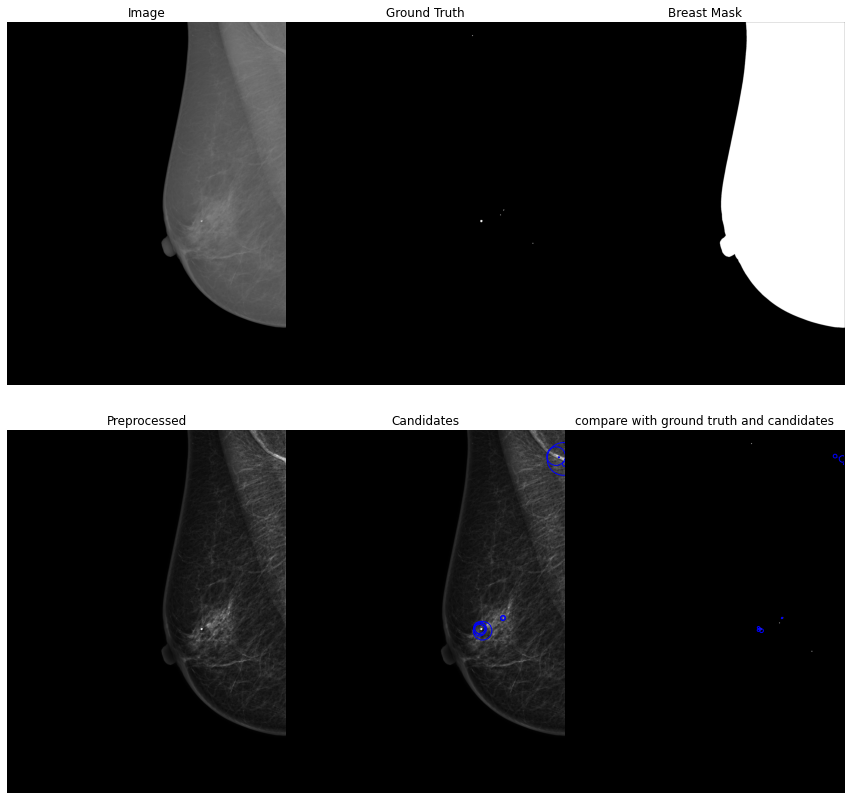

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


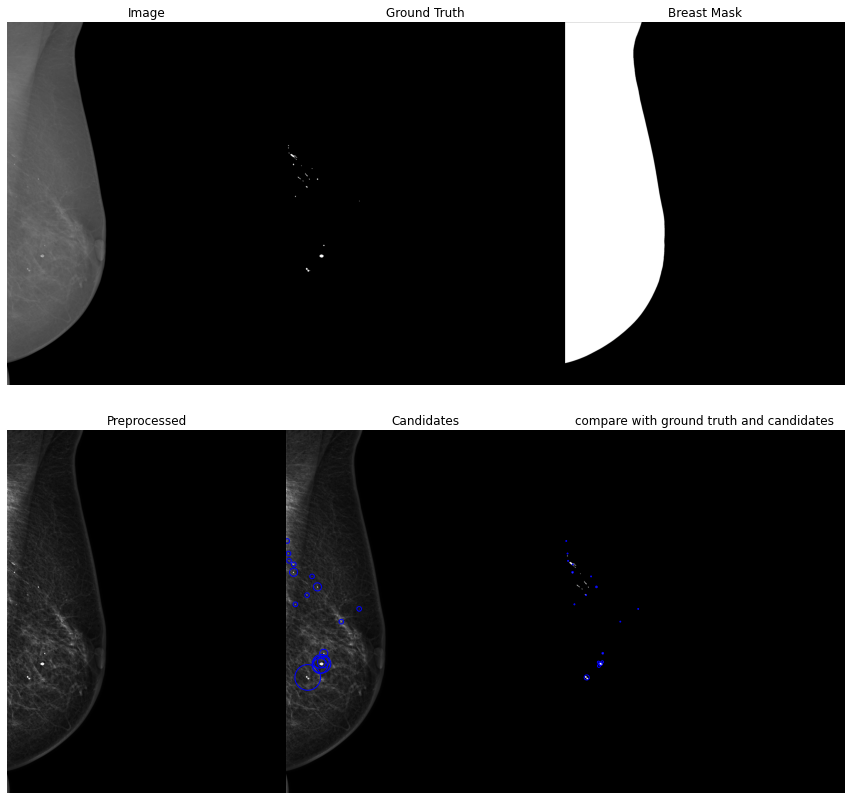

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


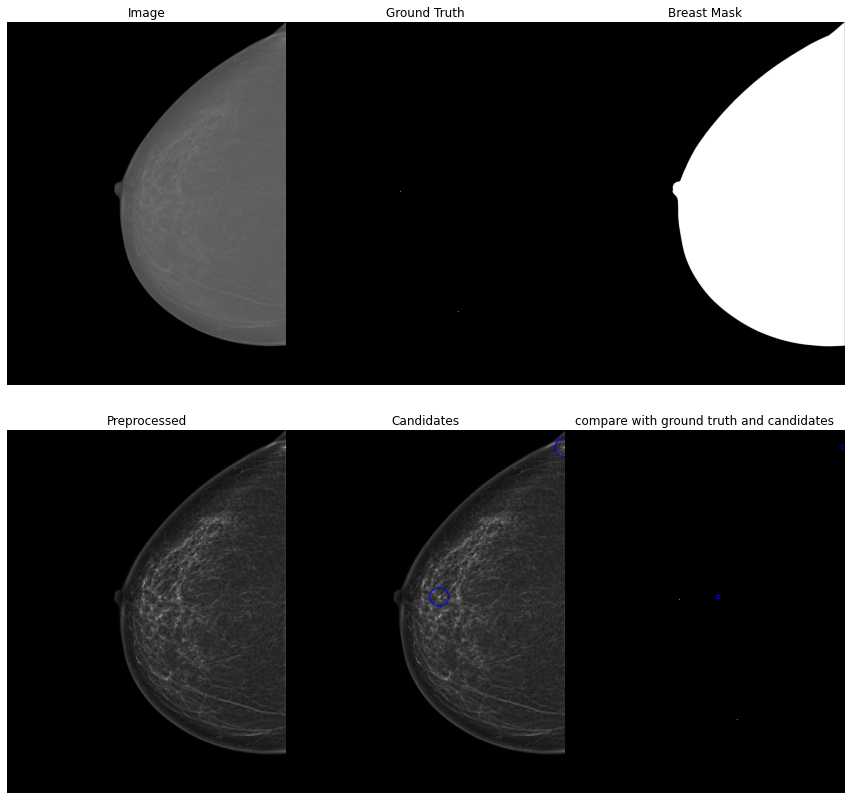

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


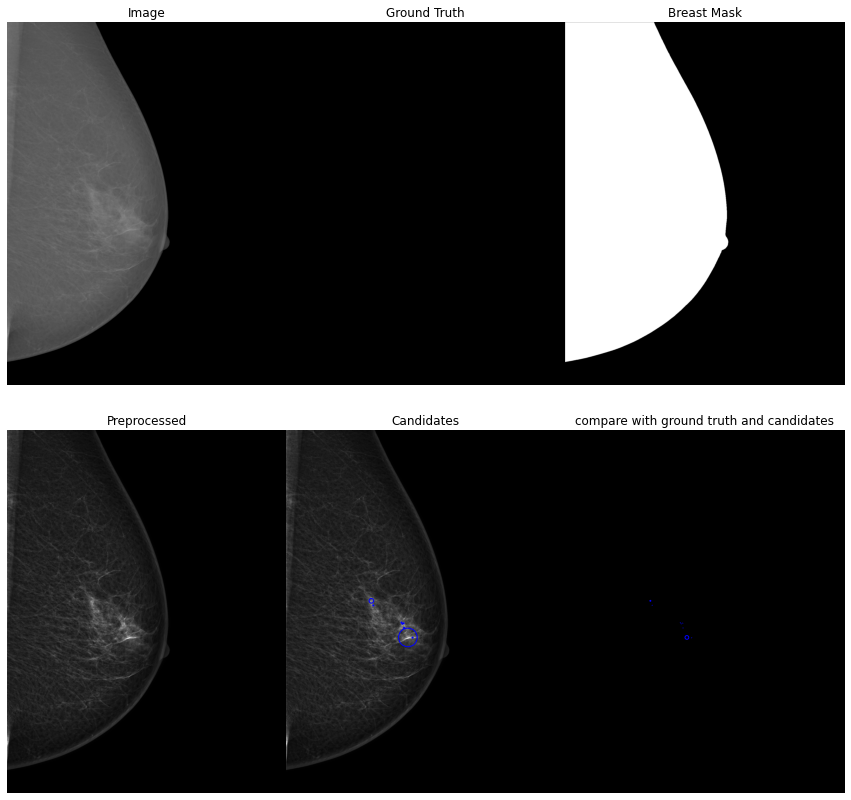

In [156]:
from matplotlib.patches import Circle
import copy


#go through the image files 
for image, breastMask, groundTruth in zip(images, breastMasks, groundTruths):
  # choose one
  # this are the last 4 of the number of the image name {numbers}_{}_{}_{}_{}_{}.tif
  # i suppose those are unique
  # if your code is working try other images!
  #print(breastMask)
  
  # 20588020, 7717, 5328, 3787, 5725, 3859, 6934, 50995872
  digits = '5872'

  if ((digits in image) and (digits in breastMask) and ('mask' in breastMask)):
    #upload
    img = cv2.imread(os.path.join(DATA_DIR,'images',image))
    imgMask = cv2.imread(os.path.join(DATA_DIR, 'masks', breastMask))
    imgGroundTruth = cv2.imread(os.path.join(DATA_DIR, 'groundtruths', image))

    # here you can prove things in the image

    # preprocessing
    imgCopy = copy.deepcopy(img)
    # preprocessed = preprocessingDeHazingPy(img, imgMask)
    preprocessed = deHazingDarkChannelPriorPy(imgCopy, imgMask)
    # after preprocessingDeHazingPy + contrast streching to see
    # preprocessed = preprocessingDeHazingPy(imgCopy,imgMask)
    

      # still missing quantum noise supression
      # details in the phd defense file

      # still missing linear streching

      # still missing CLAHE (adaptive histogram equalization) opencv library

      # fiber intersections may also appear as bright spots (false positives)

    # candidate extraction
    copyPreprocessed = copy.deepcopy(preprocessed)
    # we have to change np.float64 to np.float32 for the grayscale conversion
    # leading to a reduction of gray values
    copyPreprocessed = copyPreprocessed.astype(np.float32)
    
    copyPreprocessed = cv2.cvtColor(copyPreprocessed, cv2.COLOR_BGR2GRAY)
    candidates = candidateExtraction(copyPreprocessed, imgMask)
    # images with pectoral muscule cause false positives

    # feature extraction
    features = featuresExtraction(preprocessed, imgMask)

    # display related

    # matrix of plots and size of the figure
    figure, axis = plt.subplots(2, 3, figsize=(15,15))

    # draw in the axis the img
    axis[0][0].imshow(img)
    # switch off the axis of the plot
    axis[0][0].axis('off')
    # set a title for the plot
    axis[0][0].set_title('Image')

    axis[0][1].imshow(imgGroundTruth)
    axis[0][1].axis('off')
    axis[0][1].set_title('Ground Truth')

    axis[0][2].imshow(imgMask)
    axis[0][2].axis('off')
    axis[0][2].set_title('Breast Mask')

    axis[1][0].imshow(preprocessed, cmap='gray')
    axis[1][0].axis('off')
    axis[1][0].set_title('Preprocessed')

    # draw candidates as circles
    axis[1][1].imshow(preprocessed, cmap='gray')
    axis[1][1].axis('off')
    axis[1][1].set_title('Candidates')

    # Now, loop through coord arrays, and create a circle at each x,y pair
    for y,x,sigma in candidates:
      blob = Circle((x,y), sigma*5, color='blue', fill=False)
      axis[1][1].add_patch(blob)

    axis[1][2].imshow(imgGroundTruth, cmap='gray')
    axis[1][2].axis('off')
    axis[1][2].set_title('compare with ground truth and candidates')

    # Now, loop through coord arrays, and create a circle at each x,y pair
    for y,x,sigma in candidates:
      blob = Circle((x,y), sigma, color='blue', fill=False)
      axis[1][2].add_patch(blob)

    plt.subplots_adjust(wspace=0, hspace=0)

    # display figure with image
    plt.show()

    # display image with other function
    #cv2_imshow(features)
    


In [128]:
# save images

cv2.imwrite(os.path.join('/content',
                        'drive',
                        'MyDrive',
                        'Results',
                         "image1.png"),
            features)

True